In [55]:
import time, os

# Numpy
import numpy as np
import scipy
import sklearn
import pandas as pd

# Tensorflow and keras layers
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense,\
                                    Activation, ZeroPadding2D,\
                                    BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D,\
                                    Dropout, GlobalMaxPooling2D,\
                                    GlobalAveragePooling2D

from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Nadam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import activations
from tensorflow.keras import backend

# To generate GIFs


import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from datetime import datetime

from tqdm import tqdm

import IPython
from IPython import display
import ipywidgets as widgets


In [40]:
def create_mnist_npy():
    mnist = tf.keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    X = np.concatenate([x_train, x_test]).reshape(-1, 28*28)
    Y = np.concatenate([y_train, y_test]).reshape(-1, 1)
    #print(X.shape, Y.shape)
    T = np.concatenate([X, Y], axis=1)
    np.save("mnist.npy", T)

def load_mnist():
    T = np.load('mnist.npy')
    X = T[:, :-1].reshape(-1, 28, 28)
    Y = T[:, -1]
    x_train, x_test = X[:-10000], X[-10000:]
    y_train, y_test = Y[:-10000], Y[-10000:]
    y_train = tf.compat.v1.keras.utils.to_categorical(y_train, num_classes=10)
    y_test = tf.compat.v1.keras.utils.to_categorical(y_test, num_classes=10)
    #print(y_train.shape, y_test.shape, y_train)
    x_train = np.expand_dims(x_train, axis=-1)
    x_test = np.expand_dims(x_test, axis=-1)
    x_train = x_train.astype("float32")
    x_test = x_test.astype("float32")
    x_train /= 255.0
    x_test /= 255.0
    return (x_train, y_train, x_test, y_test)

def create_dir(dirname):
    try:
        # Create target Directory
        os.mkdir(dirname)
        #print("dirname " , filename ,  " Created ") 
    except FileExistsError:
        print("Directory " , dirname ,  " already exists")

create_dir('models')

def plot_4_by_4_images(x, save = False, savefile="img.png"):
    w=10
    h=10
    fig=plt.figure(figsize=(w, h))
    columns = 4
    rows = 5
    for i in range(1, columns*rows +1):
        img = np.random.randint(x.shape[0])
        fig.add_subplot(rows, columns, i)
        plt.imshow(x[i - 1, :, :, 0], cmap='gray')
    if save:
        plt.savefig(savefile)
    plt.show()
    plt.close()


def plot_image(img):
    plt.imshow(img, cmap='gray')
    
def generate_noise_samples(n=1):
    noise = np.random.normal(0, 1, (n, 100))
    return noise


def generate_fake_samples(generator, n=1):
    noise = generate_noise_samples(n)
    X = generator.predict(noise)
    return X


def generate_and_save_images(generator, noise_test, epoch, filename):
    display.clear_output(wait=True)
    fake_images = generator.predict(noise_test)
    plot_4_by_4_images(fake_images, save=True, savefile='models/{}/img/{:04d}.png'.format(filename, epoch))

    
def train_step(generator, discriminator, gan, real_images, batch_size=64):
    real_label = np.ones((batch_size, 1))
    generated_images = generate_fake_samples(generator, batch_size)
    generated_labels = np.zeros((batch_size, 1))

    X_dis = np.concatenate([real_images, generated_images])
    y_dis = np.zeros(2*batch_size)
    y_dis[:batch_size]=0.9
        
    discriminator.trainable = True
    discriminator.train_on_batch(X_dis, y_dis)
    #discriminator.train_on_batch(x_fake, y_fake)
        
    discriminator.trainable = False
    x_gan = generate_noise_samples(batch_size)
    y_gan = np.ones((batch_size, 1)) # We assume that we wanted true as answer from the discriminator
    gan.train_on_batch(x_gan, y_gan)

def gen_csv(data_list, filename):
    pd.DataFrame(data_list, 
                 columns =['Epoch', 'Time (s)']).to_csv ('models/%s/times.csv'%(filename), index = False, header=True)

def train(generator, discriminator, gan, dataset, epochs=50, batch_size=64, filename=str(int(time.time()))):
    m = dataset.shape[0]
    m_batch = m // batch_size
    noise_test = np.random.normal(0,1, [20, 100])
    toc = time.time()
    time_data = []
    for epoch in range(epochs):
        tic = time.time()
        for batch_num in range(m_batch):
            tuc = time.time()
            #if batch_num % 30 == 0:
                #print ('[{}%] Time for epoch {} is {} sec'.format((batch_num / m_batch) * 100,epoch + 1, time.time()-tic), end='\r')
                #generate_and_save_images(noise_test, epoch, batch_num)
                #print("[%0.2f%%] Time for epoch %d is %f sec" % ( (batch_num / m_batch) * 100, epoch + 1, time.time()-tic), end='\r')
            
            batch_slot = batch_size * batch_num
            batch = dataset[batch_slot: batch_slot + batch_size]
            train_step(generator, discriminator, gan, batch, batch_size)
        time_data.append((epoch + 1, time.time()-tic))
        generate_and_save_images(generator, noise_test, epoch, filename)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time_data[-1][1]))
    
    gen_csv(time_data, filename)
    generator.save('models/%s/generator.h5' % (filename))
    discriminator.save('models/%s/discriminator.h5' % (filename))
    gan.save('models/%s/gan.h5' % (filename))

    
def make_gif(anim_file, file_regex):
    #anim_file = 'dcgan.gif'
    fname = None
    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = glob.glob(file_regex)
        filenames = sorted(filenames)
        last = -1
        for i,filename in enumerate(filenames):
            frame = 2*(i**0.75)
            if round(frame) > round(last):
                last = frame
            else:
                continue
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

        
def format_filename(filename):
    date = datetime.now()
    date_str = "_%02d_%02d_%02d_%02d_%02d" % (date.day, date.month, date.year, date.hour, date.minute)
    create_dir('models/'+ filename)
    create_dir('models/'+ filename +"/img")
    return filename

Directory  models  already exists


In [63]:
def print_nodes(graph_def=None):
    """Prints the node names of a graph_def.
        If graph_def is not provided, use default graph_def"""

    if graph_def is None:
        nodes = [n.name for n in tf.get_default_graph().as_graph_def().node]
    else:
        nodes = [n.name for n in graph_def.node]

    print("nodes", nodes)

# https://www.dlology.com/blog/how-to-convert-trained-keras-model-to-tensorflow-and-make-prediction/
def freeze_session(session,
                   keep_var_names=None,
                   output_names=None,
                   clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import (
        convert_variables_to_constants,
        remove_training_nodes,
    )

    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(
            set(v.op.name for v in tf.global_variables()).difference(
                keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        print_nodes(input_graph_def)
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        frozen_graph = remove_training_nodes(frozen_graph)
        return frozen_graph

def save_model(sess, output_names, directory, filename):
    frozen_graph = freeze_session(sess, output_names=output_names)
    print_nodes(frozen_graph)
    tf.io.write_graph(frozen_graph, directory, filename + ".pb", as_text=False)
    print("Model saved to: %s" % filename + ".pb")

    

## Loading the dataset

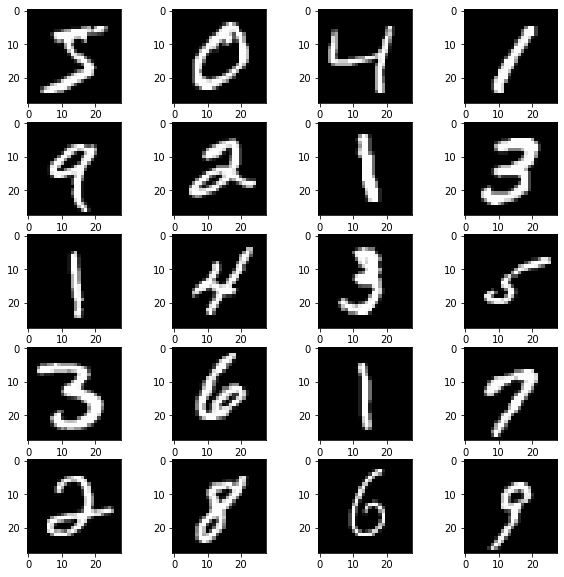

In [42]:
(x_train, y_train, x_test, y_test) = load_mnist()
plot_4_by_4_images(x_train)

## Model
The cell below includes the cryptonets model. It is composed of the following:
1. A convolutional layer , with 5 filters of size 5x5, same padding and stride 2. $n^{[l]} = \dfrac{(n^{[l-1]} + 2 * p^{[l]} - f^{[l]})}{s^{[l]}} + 1$.
 - Input: 28 x 28 x 1
 - Output: 14 x 14 x 5
2. A square activation function $g(x) = x^2$
3. An average pooling layer with 1 stride and same padding. $n^{[l]} = \dfrac{(n^{[l-1]} - f^{[l]})}{s^{[l]}} + 1$.
 - Input: 14 x 14 x 5
 - Output: 14 x 14 x5
4. Another convolutional layer , with 50 filters of size 5x5, same padding and stride 2. $n^{[l]} = \dfrac{(n^{[l-1]} + 2 * p^{[l]} - f^{[l]})}{s^{[l]}} + 1$.
 - Input: 14 x 14 x 5
 - Output: 7 x 7 x 50
5. Another average pooling layer.
 - Input: 7 x 7 x 50
 - Output: 7 x 7 x 50
6. A flattening layer, thus resulting in 7 x 7 x 50 = 2450 input attributes to the dense layer
7. A dense layer whose output is 100 from 2450
8. Another square activation layer
9. A final dense layer without any activation after it.

In [51]:
def cryptonets_model(input):

    def square_activation(x):
        return x * x

    y = Conv2D(
        filters=5,
        kernel_size=(5, 5),
        strides=(2, 2),
        padding="same",
        use_bias=True,
        input_shape=(28, 28, 1),
        name="conv2d_1",
    )(input)
    y = Activation(square_activation)(y)

    y = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding="same")(y)
    y = Conv2D(
        filters=50,
        kernel_size=(5, 5),
        strides=(2, 2),
        padding="same",
        use_bias=True,
        name="conv2d_2",
    )(y)
    y = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding="same")(y)
    y = Flatten()(y)
    y = Dense(100, use_bias=True, name="fc_1")(y)
    y = Activation(square_activation)(y)
    y = Dense(10, use_bias=True, name="fc_2")(y)

    return y

### Creating the model
The model is created in a "tensorflow-like" way. We use the Keras layers to pass through them a placeholder input.

In [52]:
x = Input(shape=(28, 28, 1), name="input")
y = cryptonets_model(x)
cryptonets_model = Model(inputs=x, outputs=y)
print(cryptonets_model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 5)         130       
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 5)         0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 14, 14, 5)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 50)          6300      
_________________________________________________________________
average_pooling2d_3 (Average (None, 7, 7, 50)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2450)              0   

### Training the model
We first define the loss and the optimizer that we are going to make use of. 

In [57]:
def loss(labels, logits):
    return tf.keras.losses.categorical_crossentropy(labels, logits, from_logits=True)

optimizer = SGD(learning_rate=0.008, momentum=0.9)
cryptonets_model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

Then, we train the model:

In [58]:
cryptonets_model.fit(x_train, y_train, 
                     epochs=50, batch_size=64, 
                     validation_data=(x_test, y_test), 
                     verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 9s 149us/sample - loss: 0.5756 - acc: 0.8085 - val_loss: 0.1286 - val_acc: 0.9612
Epoch 2/50
60000/60000 [==============================] - 8s 140us/sample - loss: 0.1221 - acc: 0.9633 - val_loss: 0.0726 - val_acc: 0.9773
Epoch 3/50
60000/60000 [==============================] - 8s 137us/sample - loss: 0.0888 - acc: 0.9731 - val_loss: 0.0522 - val_acc: 0.9824
Epoch 4/50
60000/60000 [==============================] - 8s 138us/sample - loss: 0.0703 - acc: 0.9788 - val_loss: 0.0492 - val_acc: 0.9851
Epoch 5/50
60000/60000 [==============================] - 8s 138us/sample - loss: 0.0606 - acc: 0.9814 - val_loss: 0.0490 - val_acc: 0.9853
Epoch 6/50
60000/60000 [==============================] - 8s 140us/sample - loss: 0.0519 - acc: 0.9840 - val_loss: 0.0609 - val_acc: 0.9821
Epoch 7/50
60000/60000 [==============================] - 8s 138us/sample - loss: 0.0482 - acc: 0.9851 - val_l

We save the model:

In [59]:
cryptonets_model.save('models/cryptonets_model.h5')

In [61]:
test_loss, test_acc = cryptonets_model.evaluate(x_test, y_test, verbose=1)

10000/10000 [==============================] - 1s 123us/sample - loss: 0.0543 - acc: 0.9877


## Layer Squash
After having trained the model, we have the weights of the different layers. However, as you may have realised, we make use only of two activation functions in the whole model. The operations inbetween the matrix multiplications can be compressed into a single matrix. The objective of this operation is reducing the number of multiplications that we make on the resulting Neural Network, since it directly influences the noise in the Homomorphic Encryption domain.

This process is done specifically for each network model. The reason behind. It is hardly generalizable.

In order to extract the bias ($\vec{b}$) of that operation, the neural network is passed a vector of $0$. $W^T * x + \vec{b} = \vec{b}$ if $x = \vec{0}$

Once we have the bias ($\vec{b}$), we can extract the weights by multiplying by the identity matrix ($I$), and substracting the bias from the result. $W = W*I + b - b$

In [60]:
# Squash linear layers and return squashed weights
def squash_layers(cryptonets_model, sess):
    # We get the different layers for the model
    layers = cryptonets_model.layers
    layer_names = [layer.name for layer in layers]
    conv1_weights = layers[layer_names.index('conv2d_1')].get_weights()
    conv2_weights = layers[layer_names.index('conv2d_2')].get_weights()
    fc1_weights = layers[layer_names.index('fc_1')].get_weights()
    fc2_weights = layers[layer_names.index('fc_2')].get_weights()

    # Get weight into the different layers
    y = Input(shape=(14 * 14 * 5,), name="squashed_input")
    y = Reshape((14, 14, 5))(y)
    y = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding="same")(y)
    y = Conv2D(
        filters=50,
        kernel_size=(5, 5),
        strides=(2, 2),
        padding="same",
        use_bias=True,
        trainable=False,
        kernel_initializer=tf.compat.v1.constant_initializer(conv2_weights[0]),
        bias_initializer=tf.compat.v1.constant_initializer(conv2_weights[1]),
        name="conv2d_test",
    )(y)
    y = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding="same")(y)
    y = Flatten()(y)
    y = Dense(
        100,
        use_bias=True,
        name="fc_1",
        kernel_initializer=tf.compat.v1.constant_initializer(fc1_weights[0]),
        bias_initializer=tf.compat.v1.constant_initializer(fc1_weights[1]))(y)
    
    # We initialize the session global variables for the model.
    sess.run(tf.compat.v1.global_variables_initializer())

    # Pass 0 to get bias. If we multiply by 0, we get 0
    squashed_bias = y.eval(
        session=sess,
        feed_dict={
            "squashed_input:0": np.zeros((1, 14 * 14 * 5))
        })
    print(squashed_bias)
    
    # We execute the computation on the eye/identity matrix
    squashed_bias_plus_weights = y.eval(
        session=sess, feed_dict={
            "squashed_input:0": np.eye(14 * 14 * 5)
        })
    
    # If we subtract the bias, we can get the weights
    squashed_weights = squashed_bias_plus_weights - squashed_bias
    print(squashed_bias)
    print("squashed layers")

    # Sanity check - Checking that the variation on the result is not enormous
    x_in = np.random.rand(100, 14 * 14 * 5)
    network_out = y.eval(session=sess, feed_dict={"squashed_input:0": x_in})
    linear_out = x_in.dot(squashed_weights) + squashed_bias
    assert np.max(np.abs(linear_out - network_out)) < 1e-3

    return (conv1_weights, (squashed_weights, squashed_bias), fc1_weights,
            fc2_weights)

Finally, we define our new model, where we are making use of the different weights that we extracted before.

In [62]:
def cryptonets_model_squashed(input, conv1_weights, squashed_weights,
                              fc2_weights):

    def square_activation(x):
        return x * x

    y = Conv2D(
        filters=5,
        kernel_size=(5, 5),
        strides=(2, 2),
        padding="same",
        use_bias=True,
        kernel_initializer=tf.compat.v1.constant_initializer(conv1_weights[0]),
        bias_initializer=tf.compat.v1.constant_initializer(conv1_weights[1]),
        input_shape=(28, 28, 1),
        trainable=False,
        name="convd1_1",
    )(input)
    y = Activation(square_activation)(y)

    # Using Keras model API with Flatten results in split ngraph at Flatten() or Reshape() op.
    # Use tf.reshape instead
    y = tf.reshape(y, [-1, 5 * 14 * 14])
    y = Dense(
        100,
        use_bias=True,
        name="squash_fc_1",
        trainable=False,
        kernel_initializer=tf.compat.v1.constant_initializer(
            squashed_weights[0]),
        bias_initializer=tf.compat.v1.constant_initializer(squashed_weights[1]),
    )(y)
    y = Activation(square_activation)(y)

    y = Dense(
        10,
        use_bias=True,
        trainable=False,
        kernel_initializer=tf.compat.v1.constant_initializer(fc2_weights[0]),
        bias_initializer=tf.compat.v1.constant_initializer(fc2_weights[1]),
        name="output",
    )(y)

    return y


In [64]:
# Squash weights and save model
weights = squash_layers(cryptonets_model,
                        tf.compat.v1.keras.backend.get_session())
(conv1_weights, squashed_weights, fc1_weights, fc2_weights) = weights[0:4]

tf.reset_default_graph()
sess = tf.compat.v1.Session()

x = Input(shape=(28, 28, 1), name="input")
y = model.cryptonets_model_squashed(x, conv1_weights, squashed_weights, c2_weights)
sess.run(tf.compat.v1.global_variables_initializer())
mnist_util.save_model( sess, ["output/BiasAdd"], "./models", "cryptonets")


NameError: name 'Reshape' is not defined